# Setup

In [2]:
import torch
from torch import nn
import train
import utils
from importlib import reload
reload(train)

train.set_namespace('05-resnet-03')

In [3]:
train_dl, test_dl, classes = utils.make_cifar_dataloaders_without_validation()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34

    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers

    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block

        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer

        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

# Model 1

In [5]:
model1 = train.Model('resnet-18-01', resnet18(), '40 Adam + 40 SGD')

Trainable params: 11.2 M. Untrainable params: 0.00. Buffers: 6.00 k.


Initial val_loss=4.6051, val_accuracy=0.0107
Saved model resnet-18-01 checkpoint 1. epoch=0, step=0. val_loss=4.6051, val_accuracy=0.0107
Epoch 1/40: train_loss=3.7716, train_accuracy=0.1217, val_loss=3.4441, val_accuracy=0.1828
Saved model resnet-18-01 checkpoint 1. epoch=1, step=782. train_loss=3.7716, train_accuracy=0.1217, val_loss=3.4441, val_accuracy=0.1828
Epoch 2/40: train_loss=2.9889, train_accuracy=0.2493, val_loss=2.7671, val_accuracy=0.3011
Saved model resnet-18-01 checkpoint 1. epoch=2, step=1564. train_loss=2.9889, train_accuracy=0.2493, val_loss=2.7671, val_accuracy=0.3011
Epoch 3/40: train_loss=2.5221, train_accuracy=0.3438, val_loss=2.4727, val_accuracy=0.3566
Saved model resnet-18-01 checkpoint 1. epoch=3, step=2346. train_loss=2.5221, train_accuracy=0.3438, val_loss=2.4727, val_accuracy=0.3566
Epoch 4/40: train_loss=2.2353, train_accuracy=0.4009, val_loss=2.0736, val_accuracy=0.4414
Saved model resnet-18-01 checkpoint 1. epoch=4, step=3128. train_loss=2.2353, train_a

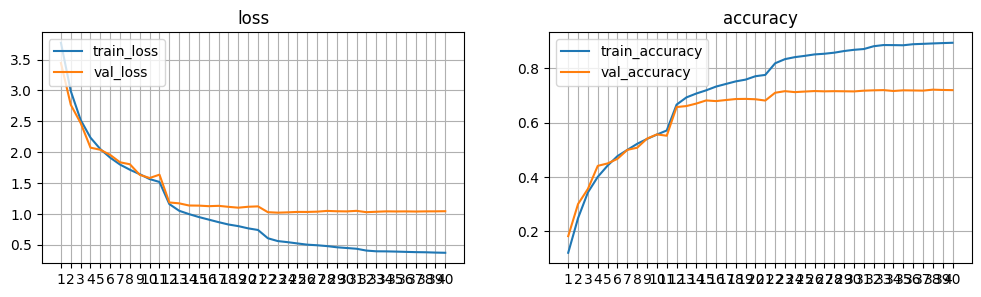

In [6]:
with model1.checkpoint(1, '40 Adam without load_best') as cp:
    cp.setup(
        loss_cls=torch.nn.CrossEntropyLoss, 
        optimizer_cls=torch.optim.Adam,
        optimizer_args=dict(lr=5e-4, weight_decay=5e-4),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=10, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=False, epochs=40, metrics=[train.metric_accuracy])
    cp.plot_metrics()


In [7]:
model1.load_checkpoint(1, from_backup=True)

Loaded model resnet-18-01 from checkpoint 1. epoch=38, step=29716. train_loss=0.3797, train_accuracy=0.8915, val_loss=1.0419, val_accuracy=0.7215


# Model 1: SGD equivalent

In [8]:
model1_1 = train.Model('resnet-18-01-01', resnet18(), '40 SGD')

Trainable params: 11.2 M. Untrainable params: 0.00. Buffers: 6.00 k.


Initial val_loss=4.6057, val_accuracy=0.0093
Saved model resnet-18-01-01 checkpoint 1. epoch=0, step=0. val_loss=4.6057, val_accuracy=0.0093


100%|██████████| 157/157 [00:02<00:00, 60.72it/s]


Epoch 1/40: train_loss=3.9563, train_accuracy=0.0912, val_loss=3.7189, val_accuracy=0.1225
Saved model resnet-18-01-01 checkpoint 1. epoch=1, step=782. train_loss=3.9563, train_accuracy=0.0912, val_loss=3.7189, val_accuracy=0.1225


100%|██████████| 157/157 [00:02<00:00, 59.82it/s]


Epoch 2/40: train_loss=3.2871, train_accuracy=0.1960, val_loss=3.1027, val_accuracy=0.2313
Saved model resnet-18-01-01 checkpoint 1. epoch=2, step=1564. train_loss=3.2871, train_accuracy=0.1960, val_loss=3.1027, val_accuracy=0.2313


100%|██████████| 157/157 [00:02<00:00, 60.02it/s]


Epoch 3/40: train_loss=2.8011, train_accuracy=0.2845, val_loss=2.6729, val_accuracy=0.3141
Saved model resnet-18-01-01 checkpoint 1. epoch=3, step=2346. train_loss=2.8011, train_accuracy=0.2845, val_loss=2.6729, val_accuracy=0.3141


100%|██████████| 157/157 [00:02<00:00, 60.22it/s]


Epoch 4/40: train_loss=2.4837, train_accuracy=0.3508, val_loss=2.5527, val_accuracy=0.3502
Saved model resnet-18-01-01 checkpoint 1. epoch=4, step=3128. train_loss=2.4837, train_accuracy=0.3508, val_loss=2.5527, val_accuracy=0.3502


100%|██████████| 157/157 [00:02<00:00, 60.49it/s]


Epoch 5/40: train_loss=2.2917, train_accuracy=0.3881, val_loss=2.1794, val_accuracy=0.4236
Saved model resnet-18-01-01 checkpoint 1. epoch=5, step=3910. train_loss=2.2917, train_accuracy=0.3881, val_loss=2.1794, val_accuracy=0.4236


100%|██████████| 157/157 [00:02<00:00, 57.79it/s]


Epoch 6/40: train_loss=2.1559, train_accuracy=0.4212, val_loss=2.2274, val_accuracy=0.4195


100%|██████████| 157/157 [00:02<00:00, 58.28it/s]


Epoch 7/40: train_loss=2.0702, train_accuracy=0.4393, val_loss=2.2484, val_accuracy=0.4141


100%|██████████| 157/157 [00:02<00:00, 59.95it/s]


Epoch 8/40: train_loss=2.0043, train_accuracy=0.4560, val_loss=2.1212, val_accuracy=0.4442
Saved model resnet-18-01-01 checkpoint 1. epoch=8, step=6256. train_loss=2.0043, train_accuracy=0.4560, val_loss=2.1212, val_accuracy=0.4442


100%|██████████| 157/157 [00:02<00:00, 60.89it/s]


Epoch 9/40: train_loss=1.9546, train_accuracy=0.4688, val_loss=2.0873, val_accuracy=0.4494
Saved model resnet-18-01-01 checkpoint 1. epoch=9, step=7038. train_loss=1.9546, train_accuracy=0.4688, val_loss=2.0873, val_accuracy=0.4494


100%|██████████| 157/157 [00:02<00:00, 58.88it/s]


Epoch 10/40: train_loss=1.9099, train_accuracy=0.4774, val_loss=2.1483, val_accuracy=0.4467


100%|██████████| 157/157 [00:02<00:00, 60.51it/s]


Epoch 11/40: train_loss=1.8863, train_accuracy=0.4868, val_loss=2.1159, val_accuracy=0.4557
Saved model resnet-18-01-01 checkpoint 1. epoch=11, step=8602. train_loss=1.8863, train_accuracy=0.4868, val_loss=2.1159, val_accuracy=0.4557


100%|██████████| 157/157 [00:02<00:00, 60.37it/s]


Epoch 12/40: train_loss=1.3438, train_accuracy=0.6179, val_loss=1.3123, val_accuracy=0.6256
Saved model resnet-18-01-01 checkpoint 1. epoch=12, step=9384. train_loss=1.3438, train_accuracy=0.6179, val_loss=1.3123, val_accuracy=0.6256


100%|██████████| 157/157 [00:02<00:00, 61.24it/s]


Epoch 13/40: train_loss=1.2123, train_accuracy=0.6495, val_loss=1.3264, val_accuracy=0.6278
Saved model resnet-18-01-01 checkpoint 1. epoch=13, step=10166. train_loss=1.2123, train_accuracy=0.6495, val_loss=1.3264, val_accuracy=0.6278


100%|██████████| 157/157 [00:02<00:00, 60.14it/s]


Epoch 14/40: train_loss=1.1594, train_accuracy=0.6640, val_loss=1.3216, val_accuracy=0.6320
Saved model resnet-18-01-01 checkpoint 1. epoch=14, step=10948. train_loss=1.1594, train_accuracy=0.6640, val_loss=1.3216, val_accuracy=0.6320


100%|██████████| 157/157 [00:02<00:00, 59.81it/s]


Epoch 15/40: train_loss=1.1319, train_accuracy=0.6712, val_loss=1.2671, val_accuracy=0.6416
Saved model resnet-18-01-01 checkpoint 1. epoch=15, step=11730. train_loss=1.1319, train_accuracy=0.6712, val_loss=1.2671, val_accuracy=0.6416


100%|██████████| 157/157 [00:02<00:00, 60.66it/s]


Epoch 16/40: train_loss=1.1050, train_accuracy=0.6748, val_loss=1.3045, val_accuracy=0.6374


100%|██████████| 157/157 [00:02<00:00, 59.71it/s]


Epoch 17/40: train_loss=1.0989, train_accuracy=0.6766, val_loss=1.3529, val_accuracy=0.6282


100%|██████████| 157/157 [00:02<00:00, 60.19it/s]


Epoch 18/40: train_loss=1.0770, train_accuracy=0.6835, val_loss=1.3253, val_accuracy=0.6280


100%|██████████| 157/157 [00:02<00:00, 56.47it/s]


Epoch 19/40: train_loss=1.0576, train_accuracy=0.6913, val_loss=1.3786, val_accuracy=0.6236


100%|██████████| 157/157 [00:02<00:00, 59.39it/s]


Epoch 20/40: train_loss=1.0403, train_accuracy=0.6922, val_loss=1.3510, val_accuracy=0.6243


100%|██████████| 157/157 [00:02<00:00, 60.29it/s]


Epoch 21/40: train_loss=1.0245, train_accuracy=0.6990, val_loss=1.3231, val_accuracy=0.6323


100%|██████████| 157/157 [00:02<00:00, 60.10it/s]


Epoch 22/40: train_loss=0.7103, train_accuracy=0.7916, val_loss=1.0005, val_accuracy=0.7131
Saved model resnet-18-01-01 checkpoint 1. epoch=22, step=17204. train_loss=0.7103, train_accuracy=0.7916, val_loss=1.0005, val_accuracy=0.7131


100%|██████████| 157/157 [00:02<00:00, 60.05it/s]


Epoch 23/40: train_loss=0.5992, train_accuracy=0.8239, val_loss=0.9957, val_accuracy=0.7173
Saved model resnet-18-01-01 checkpoint 1. epoch=23, step=17986. train_loss=0.5992, train_accuracy=0.8239, val_loss=0.9957, val_accuracy=0.7173


100%|██████████| 157/157 [00:02<00:00, 60.19it/s]


Epoch 24/40: train_loss=0.5552, train_accuracy=0.8363, val_loss=0.9962, val_accuracy=0.7218
Saved model resnet-18-01-01 checkpoint 1. epoch=24, step=18768. train_loss=0.5552, train_accuracy=0.8363, val_loss=0.9962, val_accuracy=0.7218


100%|██████████| 157/157 [00:02<00:00, 59.73it/s]


Epoch 25/40: train_loss=0.5210, train_accuracy=0.8448, val_loss=1.0061, val_accuracy=0.7163


100%|██████████| 157/157 [00:02<00:00, 59.92it/s]


Epoch 26/40: train_loss=0.4890, train_accuracy=0.8540, val_loss=1.0031, val_accuracy=0.7169


100%|██████████| 157/157 [00:02<00:00, 58.16it/s]


Epoch 27/40: train_loss=0.4590, train_accuracy=0.8611, val_loss=1.0158, val_accuracy=0.7187


100%|██████████| 157/157 [00:02<00:00, 60.34it/s]


Epoch 28/40: train_loss=0.4322, train_accuracy=0.8712, val_loss=1.0400, val_accuracy=0.7156


100%|██████████| 157/157 [00:02<00:00, 60.71it/s]


Epoch 29/40: train_loss=0.4076, train_accuracy=0.8765, val_loss=1.0676, val_accuracy=0.7137


100%|██████████| 157/157 [00:02<00:00, 60.54it/s]


Epoch 30/40: train_loss=0.3882, train_accuracy=0.8839, val_loss=1.0656, val_accuracy=0.7121


100%|██████████| 157/157 [00:02<00:00, 60.78it/s]


Epoch 31/40: train_loss=0.3684, train_accuracy=0.8888, val_loss=1.0842, val_accuracy=0.7115


100%|██████████| 157/157 [00:02<00:00, 60.54it/s]


Epoch 32/40: train_loss=0.2777, train_accuracy=0.9221, val_loss=1.0042, val_accuracy=0.7238
Saved model resnet-18-01-01 checkpoint 1. epoch=32, step=25024. train_loss=0.2777, train_accuracy=0.9221, val_loss=1.0042, val_accuracy=0.7238


100%|██████████| 157/157 [00:02<00:00, 61.46it/s]


Epoch 33/40: train_loss=0.2463, train_accuracy=0.9326, val_loss=1.0110, val_accuracy=0.7250
Saved model resnet-18-01-01 checkpoint 1. epoch=33, step=25806. train_loss=0.2463, train_accuracy=0.9326, val_loss=1.0110, val_accuracy=0.7250


100%|██████████| 157/157 [00:02<00:00, 60.48it/s]


Epoch 34/40: train_loss=0.2349, train_accuracy=0.9374, val_loss=1.0210, val_accuracy=0.7235


100%|██████████| 157/157 [00:02<00:00, 60.85it/s]


Epoch 35/40: train_loss=0.2208, train_accuracy=0.9429, val_loss=1.0177, val_accuracy=0.7247


100%|██████████| 157/157 [00:02<00:00, 61.11it/s]


Epoch 36/40: train_loss=0.2142, train_accuracy=0.9433, val_loss=1.0199, val_accuracy=0.7237


100%|██████████| 157/157 [00:02<00:00, 60.87it/s]


Epoch 37/40: train_loss=0.2084, train_accuracy=0.9458, val_loss=1.0167, val_accuracy=0.7290
Saved model resnet-18-01-01 checkpoint 1. epoch=37, step=28934. train_loss=0.2084, train_accuracy=0.9458, val_loss=1.0167, val_accuracy=0.7290


100%|██████████| 157/157 [00:02<00:00, 60.76it/s]


Epoch 38/40: train_loss=0.1996, train_accuracy=0.9486, val_loss=1.0157, val_accuracy=0.7266


100%|██████████| 157/157 [00:02<00:00, 60.54it/s]


Epoch 39/40: train_loss=0.1940, train_accuracy=0.9495, val_loss=1.0289, val_accuracy=0.7260


100%|██████████| 157/157 [00:02<00:00, 61.01it/s]


Epoch 40/40: train_loss=0.1862, train_accuracy=0.9531, val_loss=1.0251, val_accuracy=0.7269
Created backup for model resnet-18-01-01 checkpoint 1.
Saved model resnet-18-01-01 checkpoint 1. epoch=40, step=31280. train_loss=0.1862, train_accuracy=0.9531, val_loss=1.0251, val_accuracy=0.7269


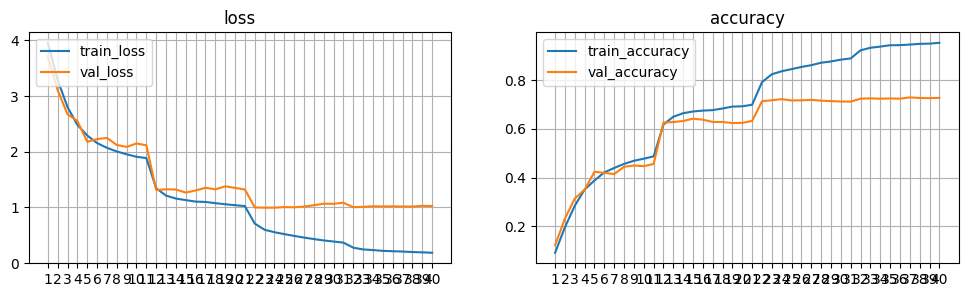

In [9]:
with model1_1.checkpoint(1, '40 SGD') as cp:
    cp.setup(
        loss_cls=torch.nn.CrossEntropyLoss, 
        optimizer_cls=torch.optim.SGD,
        optimizer_args=dict(lr=0.1, weight_decay=5e-4, momentum=0.9),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=10, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=False, epochs=40, metrics=[train.metric_accuracy])
    cp.plot_metrics()


Initial val_loss=1.0251, val_accuracy=0.7269
Saved model resnet-18-01-01 checkpoint 2. epoch=40, step=31280. val_loss=1.0251, val_accuracy=0.7269


100%|██████████| 157/157 [00:02<00:00, 60.07it/s]


Epoch 1/40: train_loss=0.1792, train_accuracy=0.9556, val_loss=1.0373, val_accuracy=0.7249


100%|██████████| 157/157 [00:02<00:00, 60.31it/s]


Epoch 2/40: train_loss=0.1647, train_accuracy=0.9612, val_loss=1.0310, val_accuracy=0.7264


100%|██████████| 157/157 [00:02<00:00, 59.53it/s]


Epoch 3/40: train_loss=0.1637, train_accuracy=0.9611, val_loss=1.0254, val_accuracy=0.7289
Saved model resnet-18-01-01 checkpoint 2. epoch=43, step=33626. train_loss=0.1637, train_accuracy=0.9611, val_loss=1.0254, val_accuracy=0.7289


100%|██████████| 157/157 [00:02<00:00, 59.99it/s]


Epoch 4/40: train_loss=0.1588, train_accuracy=0.9620, val_loss=1.0284, val_accuracy=0.7274


100%|██████████| 157/157 [00:02<00:00, 59.58it/s]


Epoch 5/40: train_loss=0.1587, train_accuracy=0.9627, val_loss=1.0282, val_accuracy=0.7284


100%|██████████| 157/157 [00:02<00:00, 60.20it/s]


Epoch 6/40: train_loss=0.1551, train_accuracy=0.9636, val_loss=1.0295, val_accuracy=0.7295
Saved model resnet-18-01-01 checkpoint 2. epoch=46, step=35972. train_loss=0.1551, train_accuracy=0.9636, val_loss=1.0295, val_accuracy=0.7295


100%|██████████| 157/157 [00:02<00:00, 59.70it/s]


Epoch 7/40: train_loss=0.1563, train_accuracy=0.9630, val_loss=1.0303, val_accuracy=0.7263


100%|██████████| 157/157 [00:02<00:00, 57.99it/s]


Epoch 8/40: train_loss=0.1538, train_accuracy=0.9640, val_loss=1.0340, val_accuracy=0.7267


100%|██████████| 157/157 [00:02<00:00, 59.27it/s]


Epoch 9/40: train_loss=0.1534, train_accuracy=0.9647, val_loss=1.0264, val_accuracy=0.7297
Saved model resnet-18-01-01 checkpoint 2. epoch=49, step=38318. train_loss=0.1534, train_accuracy=0.9647, val_loss=1.0264, val_accuracy=0.7297


100%|██████████| 157/157 [00:02<00:00, 59.31it/s]


Epoch 10/40: train_loss=0.1498, train_accuracy=0.9658, val_loss=1.0344, val_accuracy=0.7281


100%|██████████| 157/157 [00:02<00:00, 60.78it/s]


Epoch 11/40: train_loss=0.1513, train_accuracy=0.9645, val_loss=1.0343, val_accuracy=0.7268


100%|██████████| 157/157 [00:02<00:00, 60.69it/s]


Epoch 12/40: train_loss=0.1491, train_accuracy=0.9654, val_loss=1.0392, val_accuracy=0.7272


100%|██████████| 157/157 [00:02<00:00, 60.55it/s]


Epoch 13/40: train_loss=0.1465, train_accuracy=0.9652, val_loss=1.0319, val_accuracy=0.7279


100%|██████████| 157/157 [00:02<00:00, 60.78it/s]


Epoch 14/40: train_loss=0.1457, train_accuracy=0.9672, val_loss=1.0367, val_accuracy=0.7282


100%|██████████| 157/157 [00:02<00:00, 60.63it/s]


Epoch 15/40: train_loss=0.1449, train_accuracy=0.9672, val_loss=1.0348, val_accuracy=0.7273


100%|██████████| 157/157 [00:02<00:00, 60.73it/s]


Epoch 16/40: train_loss=0.1457, train_accuracy=0.9669, val_loss=1.0370, val_accuracy=0.7295


100%|██████████| 157/157 [00:02<00:00, 60.78it/s]


Epoch 17/40: train_loss=0.1428, train_accuracy=0.9680, val_loss=1.0355, val_accuracy=0.7280


100%|██████████| 157/157 [00:02<00:00, 60.92it/s]


Epoch 18/40: train_loss=0.1420, train_accuracy=0.9680, val_loss=1.0358, val_accuracy=0.7280


100%|██████████| 157/157 [00:02<00:00, 61.03it/s]


Epoch 19/40: train_loss=0.1467, train_accuracy=0.9663, val_loss=1.0380, val_accuracy=0.7259


100%|██████████| 157/157 [00:02<00:00, 61.04it/s]


Epoch 20/40: train_loss=0.1470, train_accuracy=0.9663, val_loss=1.0337, val_accuracy=0.7282


100%|██████████| 157/157 [00:02<00:00, 59.96it/s]


Epoch 21/40: train_loss=0.1446, train_accuracy=0.9667, val_loss=1.0327, val_accuracy=0.7275


100%|██████████| 157/157 [00:02<00:00, 58.22it/s]


Epoch 22/40: train_loss=0.1449, train_accuracy=0.9663, val_loss=1.0332, val_accuracy=0.7287


100%|██████████| 157/157 [00:02<00:00, 58.84it/s]


Epoch 23/40: train_loss=0.1447, train_accuracy=0.9670, val_loss=1.0292, val_accuracy=0.7293


100%|██████████| 157/157 [00:02<00:00, 60.75it/s]


Epoch 24/40: train_loss=0.1434, train_accuracy=0.9674, val_loss=1.0316, val_accuracy=0.7258


100%|██████████| 157/157 [00:02<00:00, 60.37it/s]


Epoch 25/40: train_loss=0.1437, train_accuracy=0.9671, val_loss=1.0340, val_accuracy=0.7287


100%|██████████| 157/157 [00:02<00:00, 60.37it/s]


Epoch 26/40: train_loss=0.1415, train_accuracy=0.9684, val_loss=1.0327, val_accuracy=0.7286


100%|██████████| 157/157 [00:02<00:00, 61.19it/s]


Epoch 27/40: train_loss=0.1444, train_accuracy=0.9671, val_loss=1.0320, val_accuracy=0.7288


100%|██████████| 157/157 [00:02<00:00, 60.92it/s]


Epoch 28/40: train_loss=0.1429, train_accuracy=0.9686, val_loss=1.0382, val_accuracy=0.7270


100%|██████████| 157/157 [00:02<00:00, 60.31it/s]


Epoch 29/40: train_loss=0.1420, train_accuracy=0.9682, val_loss=1.0318, val_accuracy=0.7276


100%|██████████| 157/157 [00:02<00:00, 61.16it/s]


Epoch 30/40: train_loss=0.1431, train_accuracy=0.9676, val_loss=1.0335, val_accuracy=0.7285


100%|██████████| 157/157 [00:02<00:00, 61.08it/s]


Epoch 31/40: train_loss=0.1419, train_accuracy=0.9688, val_loss=1.0313, val_accuracy=0.7281


100%|██████████| 157/157 [00:02<00:00, 60.55it/s]


Epoch 32/40: train_loss=0.1447, train_accuracy=0.9676, val_loss=1.0338, val_accuracy=0.7265


100%|██████████| 157/157 [00:02<00:00, 60.90it/s]


Epoch 33/40: train_loss=0.1431, train_accuracy=0.9678, val_loss=1.0352, val_accuracy=0.7283


100%|██████████| 157/157 [00:02<00:00, 60.89it/s]


Epoch 34/40: train_loss=0.1407, train_accuracy=0.9689, val_loss=1.0387, val_accuracy=0.7292


100%|██████████| 157/157 [00:02<00:00, 61.10it/s]


Epoch 35/40: train_loss=0.1413, train_accuracy=0.9676, val_loss=1.0375, val_accuracy=0.7291


100%|██████████| 157/157 [00:02<00:00, 60.32it/s]


Epoch 36/40: train_loss=0.1429, train_accuracy=0.9675, val_loss=1.0395, val_accuracy=0.7273


100%|██████████| 157/157 [00:02<00:00, 60.94it/s]


Epoch 37/40: train_loss=0.1432, train_accuracy=0.9672, val_loss=1.0324, val_accuracy=0.7285


100%|██████████| 157/157 [00:02<00:00, 60.47it/s]


Epoch 38/40: train_loss=0.1422, train_accuracy=0.9677, val_loss=1.0321, val_accuracy=0.7283


100%|██████████| 157/157 [00:02<00:00, 61.18it/s]


Epoch 39/40: train_loss=0.1431, train_accuracy=0.9674, val_loss=1.0326, val_accuracy=0.7271


100%|██████████| 157/157 [00:02<00:00, 61.07it/s]


Epoch 40/40: train_loss=0.1424, train_accuracy=0.9678, val_loss=1.0364, val_accuracy=0.7281
Created backup for model resnet-18-01-01 checkpoint 2.
Saved model resnet-18-01-01 checkpoint 2. epoch=80, step=62560. train_loss=0.1424, train_accuracy=0.9678, val_loss=1.0364, val_accuracy=0.7281


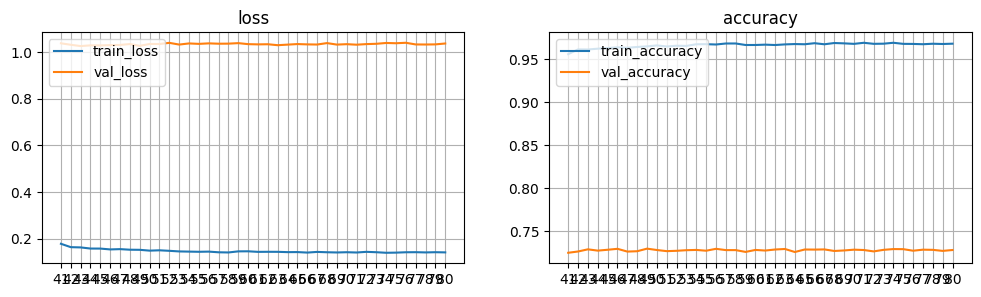

In [10]:
with model1_1.checkpoint(2, '40 more SGD') as cp:
    cp.train(train_dl, test_dl, watch='accuracy', load_best=False, epochs=40, metrics=[train.metric_accuracy])
    cp.plot_metrics()


In [20]:
model1_1.load_checkpoint(1, from_backup=True)

Loaded model resnet-18-01-01 from checkpoint 1. epoch=37, step=28934. train_loss=0.2084, train_accuracy=0.9458, val_loss=1.0167, val_accuracy=0.7290


Initial val_loss=1.0167, val_accuracy=0.7290
Saved model resnet-18-01-01 checkpoint 2.2. epoch=37, step=28934. val_loss=1.0167, val_accuracy=0.7290


100%|██████████| 157/157 [00:02<00:00, 58.77it/s]


Epoch 1/80: train_loss=0.1985, train_accuracy=0.9486, val_loss=1.0260, val_accuracy=0.7278


100%|██████████| 157/157 [00:02<00:00, 57.09it/s]


Epoch 2/80: train_loss=0.1913, train_accuracy=0.9515, val_loss=1.0258, val_accuracy=0.7254


100%|██████████| 157/157 [00:02<00:00, 56.86it/s]


Epoch 3/80: train_loss=0.1835, train_accuracy=0.9544, val_loss=1.0261, val_accuracy=0.7260


100%|██████████| 157/157 [00:02<00:00, 55.66it/s]


Epoch 4/80: train_loss=0.1789, train_accuracy=0.9548, val_loss=1.0344, val_accuracy=0.7244


100%|██████████| 157/157 [00:02<00:00, 58.28it/s]


Epoch 5/80: train_loss=0.1704, train_accuracy=0.9579, val_loss=1.0359, val_accuracy=0.7276


100%|██████████| 157/157 [00:02<00:00, 57.41it/s]


Epoch 6/80: train_loss=0.1683, train_accuracy=0.9584, val_loss=1.0416, val_accuracy=0.7265


100%|██████████| 157/157 [00:02<00:00, 59.25it/s]


Epoch 7/80: train_loss=0.1651, train_accuracy=0.9585, val_loss=1.0440, val_accuracy=0.7250


100%|██████████| 157/157 [00:02<00:00, 59.87it/s]


Epoch 8/80: train_loss=0.1604, train_accuracy=0.9603, val_loss=1.0467, val_accuracy=0.7262


100%|██████████| 157/157 [00:02<00:00, 60.12it/s]


Epoch 9/80: train_loss=0.1532, train_accuracy=0.9625, val_loss=1.0570, val_accuracy=0.7226


100%|██████████| 157/157 [00:02<00:00, 60.37it/s]


Epoch 10/80: train_loss=0.1489, train_accuracy=0.9648, val_loss=1.0513, val_accuracy=0.7258


100%|██████████| 157/157 [00:02<00:00, 59.49it/s]


Epoch 11/80: train_loss=0.1436, train_accuracy=0.9667, val_loss=1.0557, val_accuracy=0.7270


100%|██████████| 157/157 [00:02<00:00, 59.33it/s]


Epoch 12/80: train_loss=0.1398, train_accuracy=0.9675, val_loss=1.0612, val_accuracy=0.7255


100%|██████████| 157/157 [00:02<00:00, 59.71it/s]


Epoch 13/80: train_loss=0.1375, train_accuracy=0.9680, val_loss=1.0653, val_accuracy=0.7234


100%|██████████| 157/157 [00:02<00:00, 59.81it/s]


Epoch 14/80: train_loss=0.1336, train_accuracy=0.9685, val_loss=1.0710, val_accuracy=0.7268


100%|██████████| 157/157 [00:02<00:00, 59.35it/s]


Epoch 15/80: train_loss=0.1286, train_accuracy=0.9709, val_loss=1.0694, val_accuracy=0.7263


100%|██████████| 157/157 [00:02<00:00, 56.39it/s]


Epoch 16/80: train_loss=0.1264, train_accuracy=0.9712, val_loss=1.0646, val_accuracy=0.7243


100%|██████████| 157/157 [00:02<00:00, 59.08it/s]


Epoch 17/80: train_loss=0.1232, train_accuracy=0.9724, val_loss=1.0721, val_accuracy=0.7273


100%|██████████| 157/157 [00:02<00:00, 59.46it/s]


Epoch 18/80: train_loss=0.1190, train_accuracy=0.9744, val_loss=1.0691, val_accuracy=0.7293
Saved model resnet-18-01-01 checkpoint 2.2. epoch=55, step=43010. train_loss=0.1190, train_accuracy=0.9744, val_loss=1.0691, val_accuracy=0.7293


100%|██████████| 157/157 [00:02<00:00, 60.46it/s]


Epoch 19/80: train_loss=0.1168, train_accuracy=0.9742, val_loss=1.0825, val_accuracy=0.7282


100%|██████████| 157/157 [00:02<00:00, 57.90it/s]


Epoch 20/80: train_loss=0.1157, train_accuracy=0.9748, val_loss=1.0727, val_accuracy=0.7230


100%|██████████| 157/157 [00:02<00:00, 59.37it/s]


Epoch 21/80: train_loss=0.1089, train_accuracy=0.9758, val_loss=1.0872, val_accuracy=0.7257


100%|██████████| 157/157 [00:02<00:00, 60.00it/s]


Epoch 22/80: train_loss=0.1078, train_accuracy=0.9765, val_loss=1.0759, val_accuracy=0.7261


100%|██████████| 157/157 [00:02<00:00, 58.97it/s]


Epoch 23/80: train_loss=0.1022, train_accuracy=0.9788, val_loss=1.0912, val_accuracy=0.7263


100%|██████████| 157/157 [00:02<00:00, 57.33it/s]


Epoch 24/80: train_loss=0.1027, train_accuracy=0.9782, val_loss=1.0905, val_accuracy=0.7277


100%|██████████| 157/157 [00:02<00:00, 59.75it/s]


Epoch 25/80: train_loss=0.0988, train_accuracy=0.9797, val_loss=1.0984, val_accuracy=0.7237


100%|██████████| 157/157 [00:02<00:00, 59.58it/s]


Epoch 26/80: train_loss=0.0978, train_accuracy=0.9789, val_loss=1.0867, val_accuracy=0.7274


100%|██████████| 157/157 [00:02<00:00, 58.82it/s]


Epoch 27/80: train_loss=0.0976, train_accuracy=0.9791, val_loss=1.1061, val_accuracy=0.7238


100%|██████████| 157/157 [00:02<00:00, 59.92it/s]


Epoch 28/80: train_loss=0.0928, train_accuracy=0.9802, val_loss=1.1014, val_accuracy=0.7228


100%|██████████| 157/157 [00:02<00:00, 59.65it/s]


Epoch 29/80: train_loss=0.0907, train_accuracy=0.9819, val_loss=1.1034, val_accuracy=0.7252


100%|██████████| 157/157 [00:02<00:00, 60.23it/s]


Epoch 30/80: train_loss=0.0862, train_accuracy=0.9833, val_loss=1.1068, val_accuracy=0.7226


100%|██████████| 157/157 [00:02<00:00, 60.17it/s]


Epoch 31/80: train_loss=0.0878, train_accuracy=0.9815, val_loss=1.1069, val_accuracy=0.7225


100%|██████████| 157/157 [00:02<00:00, 59.34it/s]


Epoch 32/80: train_loss=0.0875, train_accuracy=0.9818, val_loss=1.1141, val_accuracy=0.7249


100%|██████████| 157/157 [00:02<00:00, 59.82it/s]


Epoch 33/80: train_loss=0.0851, train_accuracy=0.9831, val_loss=1.1093, val_accuracy=0.7244


100%|██████████| 157/157 [00:02<00:00, 60.32it/s]


Epoch 34/80: train_loss=0.0817, train_accuracy=0.9835, val_loss=1.1051, val_accuracy=0.7257


100%|██████████| 157/157 [00:02<00:00, 59.91it/s]


Epoch 35/80: train_loss=0.0814, train_accuracy=0.9842, val_loss=1.1086, val_accuracy=0.7253


100%|██████████| 157/157 [00:02<00:00, 59.94it/s]


Epoch 36/80: train_loss=0.0760, train_accuracy=0.9857, val_loss=1.1167, val_accuracy=0.7258


100%|██████████| 157/157 [00:02<00:00, 60.09it/s]


Epoch 37/80: train_loss=0.0800, train_accuracy=0.9834, val_loss=1.1151, val_accuracy=0.7260


100%|██████████| 157/157 [00:02<00:00, 60.29it/s]


Epoch 38/80: train_loss=0.0764, train_accuracy=0.9857, val_loss=1.1222, val_accuracy=0.7254


100%|██████████| 157/157 [00:02<00:00, 60.18it/s]


Epoch 39/80: train_loss=0.0724, train_accuracy=0.9875, val_loss=1.1163, val_accuracy=0.7247


100%|██████████| 157/157 [00:02<00:00, 60.04it/s]


Epoch 40/80: train_loss=0.0703, train_accuracy=0.9870, val_loss=1.1150, val_accuracy=0.7294
Saved model resnet-18-01-01 checkpoint 2.2. epoch=77, step=60214. train_loss=0.0703, train_accuracy=0.9870, val_loss=1.1150, val_accuracy=0.7294


100%|██████████| 157/157 [00:02<00:00, 59.96it/s]


Epoch 41/80: train_loss=0.0637, train_accuracy=0.9896, val_loss=1.1098, val_accuracy=0.7292


100%|██████████| 157/157 [00:02<00:00, 59.48it/s]


Epoch 42/80: train_loss=0.0616, train_accuracy=0.9904, val_loss=1.1062, val_accuracy=0.7300
Saved model resnet-18-01-01 checkpoint 2.2. epoch=79, step=61778. train_loss=0.0616, train_accuracy=0.9904, val_loss=1.1062, val_accuracy=0.7300


100%|██████████| 157/157 [00:02<00:00, 59.84it/s]


Epoch 43/80: train_loss=0.0605, train_accuracy=0.9900, val_loss=1.1083, val_accuracy=0.7276


100%|██████████| 157/157 [00:02<00:00, 59.63it/s]


Epoch 44/80: train_loss=0.0587, train_accuracy=0.9911, val_loss=1.1074, val_accuracy=0.7268


100%|██████████| 157/157 [00:02<00:00, 60.12it/s]


Epoch 45/80: train_loss=0.0591, train_accuracy=0.9903, val_loss=1.1073, val_accuracy=0.7302
Saved model resnet-18-01-01 checkpoint 2.2. epoch=82, step=64124. train_loss=0.0591, train_accuracy=0.9903, val_loss=1.1073, val_accuracy=0.7302


100%|██████████| 157/157 [00:02<00:00, 59.61it/s]


Epoch 46/80: train_loss=0.0566, train_accuracy=0.9914, val_loss=1.1059, val_accuracy=0.7305
Saved model resnet-18-01-01 checkpoint 2.2. epoch=83, step=64906. train_loss=0.0566, train_accuracy=0.9914, val_loss=1.1059, val_accuracy=0.7305


100%|██████████| 157/157 [00:02<00:00, 58.98it/s]


Epoch 47/80: train_loss=0.0559, train_accuracy=0.9915, val_loss=1.1037, val_accuracy=0.7293


100%|██████████| 157/157 [00:02<00:00, 60.08it/s]


Epoch 48/80: train_loss=0.0561, train_accuracy=0.9911, val_loss=1.1021, val_accuracy=0.7283


100%|██████████| 157/157 [00:02<00:00, 59.72it/s]


Epoch 49/80: train_loss=0.0564, train_accuracy=0.9910, val_loss=1.1069, val_accuracy=0.7300


100%|██████████| 157/157 [00:02<00:00, 60.01it/s]


Epoch 50/80: train_loss=0.0547, train_accuracy=0.9919, val_loss=1.1023, val_accuracy=0.7285


100%|██████████| 157/157 [00:02<00:00, 60.15it/s]


Epoch 51/80: train_loss=0.0552, train_accuracy=0.9913, val_loss=1.1070, val_accuracy=0.7277


100%|██████████| 157/157 [00:02<00:00, 59.94it/s]


Epoch 52/80: train_loss=0.0542, train_accuracy=0.9914, val_loss=1.1032, val_accuracy=0.7297


100%|██████████| 157/157 [00:02<00:00, 59.15it/s]


Epoch 53/80: train_loss=0.0550, train_accuracy=0.9915, val_loss=1.1074, val_accuracy=0.7298


100%|██████████| 157/157 [00:02<00:00, 59.92it/s]


Epoch 54/80: train_loss=0.0525, train_accuracy=0.9925, val_loss=1.1002, val_accuracy=0.7301


100%|██████████| 157/157 [00:02<00:00, 59.42it/s]


Epoch 55/80: train_loss=0.0526, train_accuracy=0.9920, val_loss=1.1039, val_accuracy=0.7283


100%|██████████| 157/157 [00:02<00:00, 59.94it/s]


Epoch 56/80: train_loss=0.0536, train_accuracy=0.9914, val_loss=1.1000, val_accuracy=0.7299


100%|██████████| 157/157 [00:02<00:00, 58.32it/s]


Epoch 57/80: train_loss=0.0539, train_accuracy=0.9916, val_loss=1.1031, val_accuracy=0.7280


100%|██████████| 157/157 [00:02<00:00, 60.15it/s]


Epoch 58/80: train_loss=0.0527, train_accuracy=0.9917, val_loss=1.1017, val_accuracy=0.7287


100%|██████████| 157/157 [00:02<00:00, 57.90it/s]


Epoch 59/80: train_loss=0.0534, train_accuracy=0.9915, val_loss=1.1037, val_accuracy=0.7301


100%|██████████| 157/157 [00:02<00:00, 59.76it/s]


Epoch 60/80: train_loss=0.0514, train_accuracy=0.9924, val_loss=1.1031, val_accuracy=0.7289


100%|██████████| 157/157 [00:02<00:00, 59.03it/s]


Epoch 61/80: train_loss=0.0521, train_accuracy=0.9925, val_loss=1.1035, val_accuracy=0.7309
Saved model resnet-18-01-01 checkpoint 2.2. epoch=98, step=76636. train_loss=0.0521, train_accuracy=0.9925, val_loss=1.1035, val_accuracy=0.7309


100%|██████████| 157/157 [00:02<00:00, 57.61it/s]


Epoch 62/80: train_loss=0.0514, train_accuracy=0.9924, val_loss=1.1107, val_accuracy=0.7284


100%|██████████| 157/157 [00:02<00:00, 60.10it/s]


Epoch 63/80: train_loss=0.0509, train_accuracy=0.9923, val_loss=1.1056, val_accuracy=0.7295


100%|██████████| 157/157 [00:02<00:00, 60.16it/s]


Epoch 64/80: train_loss=0.0515, train_accuracy=0.9917, val_loss=1.1101, val_accuracy=0.7290


100%|██████████| 157/157 [00:02<00:00, 59.99it/s]


Epoch 65/80: train_loss=0.0503, train_accuracy=0.9924, val_loss=1.1082, val_accuracy=0.7296


100%|██████████| 157/157 [00:02<00:00, 59.11it/s]


Epoch 66/80: train_loss=0.0490, train_accuracy=0.9927, val_loss=1.1051, val_accuracy=0.7308


100%|██████████| 157/157 [00:02<00:00, 59.83it/s]


Epoch 67/80: train_loss=0.0502, train_accuracy=0.9922, val_loss=1.1051, val_accuracy=0.7329
Saved model resnet-18-01-01 checkpoint 2.2. epoch=104, step=81328. train_loss=0.0502, train_accuracy=0.9922, val_loss=1.1051, val_accuracy=0.7329


100%|██████████| 157/157 [00:02<00:00, 60.00it/s]


Epoch 68/80: train_loss=0.0485, train_accuracy=0.9930, val_loss=1.1054, val_accuracy=0.7296


100%|██████████| 157/157 [00:02<00:00, 60.07it/s]


Epoch 69/80: train_loss=0.0492, train_accuracy=0.9928, val_loss=1.1119, val_accuracy=0.7306


100%|██████████| 157/157 [00:02<00:00, 60.23it/s]


Epoch 70/80: train_loss=0.0491, train_accuracy=0.9925, val_loss=1.1130, val_accuracy=0.7291


100%|██████████| 157/157 [00:02<00:00, 55.58it/s]


Epoch 71/80: train_loss=0.0480, train_accuracy=0.9934, val_loss=1.1078, val_accuracy=0.7291


100%|██████████| 157/157 [00:02<00:00, 58.98it/s]


Epoch 72/80: train_loss=0.0489, train_accuracy=0.9924, val_loss=1.1038, val_accuracy=0.7272


100%|██████████| 157/157 [00:02<00:00, 59.96it/s]


Epoch 73/80: train_loss=0.0469, train_accuracy=0.9934, val_loss=1.1023, val_accuracy=0.7301


100%|██████████| 157/157 [00:02<00:00, 55.35it/s]


Epoch 74/80: train_loss=0.0477, train_accuracy=0.9931, val_loss=1.1091, val_accuracy=0.7294


100%|██████████| 157/157 [00:02<00:00, 59.63it/s]


Epoch 75/80: train_loss=0.0484, train_accuracy=0.9929, val_loss=1.1064, val_accuracy=0.7290


100%|██████████| 157/157 [00:02<00:00, 56.30it/s]


Epoch 76/80: train_loss=0.0484, train_accuracy=0.9923, val_loss=1.1110, val_accuracy=0.7292


100%|██████████| 157/157 [00:02<00:00, 58.97it/s]


Epoch 77/80: train_loss=0.0493, train_accuracy=0.9925, val_loss=1.1169, val_accuracy=0.7284


100%|██████████| 157/157 [00:02<00:00, 59.86it/s]


Epoch 78/80: train_loss=0.0463, train_accuracy=0.9939, val_loss=1.1130, val_accuracy=0.7271


100%|██████████| 157/157 [00:02<00:00, 59.47it/s]


Epoch 79/80: train_loss=0.0483, train_accuracy=0.9931, val_loss=1.1118, val_accuracy=0.7291


100%|██████████| 157/157 [00:02<00:00, 59.89it/s]


Epoch 80/80: train_loss=0.0460, train_accuracy=0.9941, val_loss=1.1107, val_accuracy=0.7284
Loaded model resnet-18-01-01 from checkpoint 2.2. epoch=104, step=81328. train_loss=0.0502, train_accuracy=0.9922, val_loss=1.1051, val_accuracy=0.7329


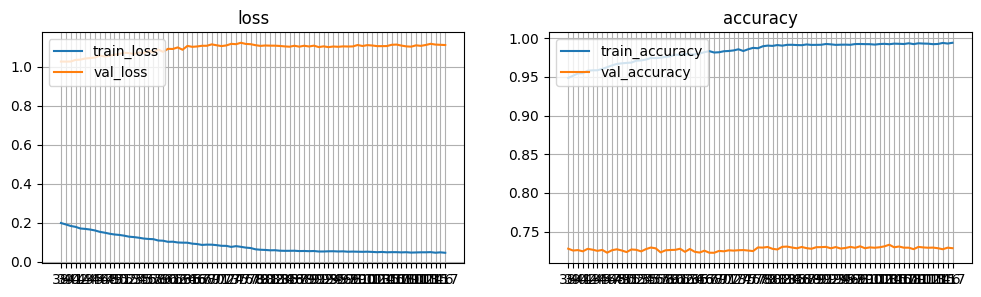

In [21]:
with model1_1.checkpoint(2.2, '80 more SGD') as cp:
    cp.setup(
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=40, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=80, metrics=[train.metric_accuracy])
    cp.plot_metrics()


In [22]:
model1_1.load_checkpoint(1, from_backup=True)

Loaded model resnet-18-01-01 from checkpoint 1. epoch=37, step=28934. train_loss=0.2084, train_accuracy=0.9458, val_loss=1.0167, val_accuracy=0.7290


Initial val_loss=1.0167, val_accuracy=0.7290
Saved model resnet-18-01-01 checkpoint 2.3. epoch=37, step=28934. val_loss=1.0167, val_accuracy=0.7290


100%|██████████| 157/157 [00:02<00:00, 61.22it/s]


Epoch 1/120: train_loss=0.1993, train_accuracy=0.9489, val_loss=1.0214, val_accuracy=0.7247


100%|██████████| 157/157 [00:02<00:00, 58.83it/s]


Epoch 2/120: train_loss=0.1900, train_accuracy=0.9519, val_loss=1.0187, val_accuracy=0.7249


100%|██████████| 157/157 [00:02<00:00, 60.65it/s]


Epoch 3/120: train_loss=0.1853, train_accuracy=0.9532, val_loss=1.0283, val_accuracy=0.7279


100%|██████████| 157/157 [00:02<00:00, 60.21it/s]


Epoch 4/120: train_loss=0.1783, train_accuracy=0.9547, val_loss=1.0358, val_accuracy=0.7244


100%|██████████| 157/157 [00:02<00:00, 60.75it/s]


Epoch 5/120: train_loss=0.1755, train_accuracy=0.9563, val_loss=1.0371, val_accuracy=0.7251


100%|██████████| 157/157 [00:02<00:00, 60.31it/s]


Epoch 6/120: train_loss=0.1674, train_accuracy=0.9592, val_loss=1.0427, val_accuracy=0.7254


100%|██████████| 157/157 [00:02<00:00, 59.25it/s]


Epoch 7/120: train_loss=0.1627, train_accuracy=0.9601, val_loss=1.0458, val_accuracy=0.7220


100%|██████████| 157/157 [00:02<00:00, 55.38it/s]


Epoch 8/120: train_loss=0.1563, train_accuracy=0.9612, val_loss=1.0449, val_accuracy=0.7262


100%|██████████| 157/157 [00:02<00:00, 59.66it/s]


Epoch 9/120: train_loss=0.1570, train_accuracy=0.9630, val_loss=1.0473, val_accuracy=0.7248


100%|██████████| 157/157 [00:02<00:00, 57.93it/s]


Epoch 10/120: train_loss=0.1483, train_accuracy=0.9652, val_loss=1.0534, val_accuracy=0.7264


100%|██████████| 157/157 [00:02<00:00, 60.51it/s]


Epoch 11/120: train_loss=0.1450, train_accuracy=0.9657, val_loss=1.0505, val_accuracy=0.7260


100%|██████████| 157/157 [00:02<00:00, 58.82it/s]


Epoch 12/120: train_loss=0.1394, train_accuracy=0.9672, val_loss=1.0628, val_accuracy=0.7256


100%|██████████| 157/157 [00:02<00:00, 60.51it/s]


Epoch 13/120: train_loss=0.1359, train_accuracy=0.9674, val_loss=1.0645, val_accuracy=0.7248


100%|██████████| 157/157 [00:02<00:00, 60.68it/s]


Epoch 14/120: train_loss=0.1332, train_accuracy=0.9699, val_loss=1.0641, val_accuracy=0.7283


100%|██████████| 157/157 [00:02<00:00, 60.22it/s]


Epoch 15/120: train_loss=0.1306, train_accuracy=0.9707, val_loss=1.0724, val_accuracy=0.7243


100%|██████████| 157/157 [00:02<00:00, 58.74it/s]


Epoch 16/120: train_loss=0.1284, train_accuracy=0.9696, val_loss=1.0800, val_accuracy=0.7257


100%|██████████| 157/157 [00:02<00:00, 59.57it/s]


Epoch 17/120: train_loss=0.1223, train_accuracy=0.9728, val_loss=1.0702, val_accuracy=0.7274


100%|██████████| 157/157 [00:02<00:00, 59.84it/s]


Epoch 18/120: train_loss=0.1206, train_accuracy=0.9727, val_loss=1.0793, val_accuracy=0.7283


100%|██████████| 157/157 [00:02<00:00, 58.83it/s]


Epoch 19/120: train_loss=0.1157, train_accuracy=0.9756, val_loss=1.0808, val_accuracy=0.7232


100%|██████████| 157/157 [00:02<00:00, 58.93it/s]


Epoch 20/120: train_loss=0.1101, train_accuracy=0.9764, val_loss=1.0824, val_accuracy=0.7272


100%|██████████| 157/157 [00:02<00:00, 60.60it/s]


Epoch 21/120: train_loss=0.1111, train_accuracy=0.9755, val_loss=1.0810, val_accuracy=0.7268


100%|██████████| 157/157 [00:02<00:00, 58.63it/s]


Epoch 22/120: train_loss=0.1095, train_accuracy=0.9766, val_loss=1.0948, val_accuracy=0.7231


100%|██████████| 157/157 [00:02<00:00, 60.03it/s]


Epoch 23/120: train_loss=0.1031, train_accuracy=0.9782, val_loss=1.0884, val_accuracy=0.7268


100%|██████████| 157/157 [00:02<00:00, 60.04it/s]


Epoch 24/120: train_loss=0.1009, train_accuracy=0.9793, val_loss=1.0895, val_accuracy=0.7260


100%|██████████| 157/157 [00:02<00:00, 58.81it/s]


Epoch 25/120: train_loss=0.0970, train_accuracy=0.9798, val_loss=1.0930, val_accuracy=0.7271


100%|██████████| 157/157 [00:02<00:00, 58.61it/s]


Epoch 26/120: train_loss=0.0961, train_accuracy=0.9807, val_loss=1.0938, val_accuracy=0.7271


100%|██████████| 157/157 [00:02<00:00, 59.11it/s]


Epoch 27/120: train_loss=0.0921, train_accuracy=0.9808, val_loss=1.1011, val_accuracy=0.7227


100%|██████████| 157/157 [00:02<00:00, 57.78it/s]


Epoch 28/120: train_loss=0.0953, train_accuracy=0.9793, val_loss=1.0961, val_accuracy=0.7256


100%|██████████| 157/157 [00:02<00:00, 59.22it/s]


Epoch 29/120: train_loss=0.0902, train_accuracy=0.9812, val_loss=1.1036, val_accuracy=0.7275


100%|██████████| 157/157 [00:02<00:00, 60.51it/s]


Epoch 30/120: train_loss=0.0857, train_accuracy=0.9833, val_loss=1.1024, val_accuracy=0.7259


100%|██████████| 157/157 [00:02<00:00, 60.06it/s]


Epoch 31/120: train_loss=0.0882, train_accuracy=0.9820, val_loss=1.0975, val_accuracy=0.7301
Saved model resnet-18-01-01 checkpoint 2.3. epoch=68, step=53176. train_loss=0.0882, train_accuracy=0.9820, val_loss=1.0975, val_accuracy=0.7301


100%|██████████| 157/157 [00:02<00:00, 60.45it/s]


Epoch 32/120: train_loss=0.0848, train_accuracy=0.9832, val_loss=1.1085, val_accuracy=0.7274


100%|██████████| 157/157 [00:02<00:00, 59.64it/s]


Epoch 33/120: train_loss=0.0835, train_accuracy=0.9836, val_loss=1.1096, val_accuracy=0.7257


100%|██████████| 157/157 [00:02<00:00, 59.76it/s]


Epoch 34/120: train_loss=0.0808, train_accuracy=0.9843, val_loss=1.1107, val_accuracy=0.7257


100%|██████████| 157/157 [00:02<00:00, 59.30it/s]


Epoch 35/120: train_loss=0.0781, train_accuracy=0.9853, val_loss=1.1085, val_accuracy=0.7265


100%|██████████| 157/157 [00:02<00:00, 60.82it/s]


Epoch 36/120: train_loss=0.0769, train_accuracy=0.9855, val_loss=1.1174, val_accuracy=0.7255


100%|██████████| 157/157 [00:02<00:00, 59.84it/s]


Epoch 37/120: train_loss=0.0756, train_accuracy=0.9856, val_loss=1.0986, val_accuracy=0.7311
Saved model resnet-18-01-01 checkpoint 2.3. epoch=74, step=57868. train_loss=0.0756, train_accuracy=0.9856, val_loss=1.0986, val_accuracy=0.7311


100%|██████████| 157/157 [00:02<00:00, 60.03it/s]


Epoch 38/120: train_loss=0.0743, train_accuracy=0.9861, val_loss=1.1155, val_accuracy=0.7281


100%|██████████| 157/157 [00:02<00:00, 60.49it/s]


Epoch 39/120: train_loss=0.0736, train_accuracy=0.9863, val_loss=1.1132, val_accuracy=0.7267


100%|██████████| 157/157 [00:02<00:00, 59.60it/s]


Epoch 40/120: train_loss=0.0720, train_accuracy=0.9865, val_loss=1.1039, val_accuracy=0.7309


100%|██████████| 157/157 [00:02<00:00, 60.91it/s]


Epoch 41/120: train_loss=0.0638, train_accuracy=0.9891, val_loss=1.1013, val_accuracy=0.7289


100%|██████████| 157/157 [00:02<00:00, 60.57it/s]


Epoch 42/120: train_loss=0.0607, train_accuracy=0.9907, val_loss=1.0963, val_accuracy=0.7303


100%|██████████| 157/157 [00:02<00:00, 59.79it/s]


Epoch 43/120: train_loss=0.0607, train_accuracy=0.9896, val_loss=1.0978, val_accuracy=0.7310


100%|██████████| 157/157 [00:02<00:00, 60.40it/s]


Epoch 44/120: train_loss=0.0582, train_accuracy=0.9907, val_loss=1.0994, val_accuracy=0.7293


100%|██████████| 157/157 [00:02<00:00, 59.16it/s]


Epoch 45/120: train_loss=0.0592, train_accuracy=0.9908, val_loss=1.0973, val_accuracy=0.7288


100%|██████████| 157/157 [00:02<00:00, 59.58it/s]


Epoch 46/120: train_loss=0.0567, train_accuracy=0.9911, val_loss=1.1026, val_accuracy=0.7290


100%|██████████| 157/157 [00:02<00:00, 60.63it/s]


Epoch 47/120: train_loss=0.0570, train_accuracy=0.9904, val_loss=1.0995, val_accuracy=0.7293


100%|██████████| 157/157 [00:02<00:00, 59.81it/s]


Epoch 48/120: train_loss=0.0554, train_accuracy=0.9915, val_loss=1.1029, val_accuracy=0.7299


100%|██████████| 157/157 [00:02<00:00, 59.93it/s]


Epoch 49/120: train_loss=0.0569, train_accuracy=0.9907, val_loss=1.1032, val_accuracy=0.7299


100%|██████████| 157/157 [00:02<00:00, 59.90it/s]


Epoch 50/120: train_loss=0.0552, train_accuracy=0.9914, val_loss=1.1012, val_accuracy=0.7307


100%|██████████| 157/157 [00:02<00:00, 60.34it/s]


Epoch 51/120: train_loss=0.0558, train_accuracy=0.9915, val_loss=1.0988, val_accuracy=0.7292


100%|██████████| 157/157 [00:02<00:00, 59.37it/s]


Epoch 52/120: train_loss=0.0561, train_accuracy=0.9910, val_loss=1.0919, val_accuracy=0.7311


100%|██████████| 157/157 [00:02<00:00, 59.28it/s]


Epoch 53/120: train_loss=0.0554, train_accuracy=0.9919, val_loss=1.0996, val_accuracy=0.7314
Saved model resnet-18-01-01 checkpoint 2.3. epoch=90, step=70380. train_loss=0.0554, train_accuracy=0.9919, val_loss=1.0996, val_accuracy=0.7314


100%|██████████| 157/157 [00:02<00:00, 55.07it/s]


Epoch 54/120: train_loss=0.0534, train_accuracy=0.9918, val_loss=1.0981, val_accuracy=0.7312


100%|██████████| 157/157 [00:02<00:00, 56.12it/s]


Epoch 55/120: train_loss=0.0531, train_accuracy=0.9918, val_loss=1.1026, val_accuracy=0.7317
Saved model resnet-18-01-01 checkpoint 2.3. epoch=92, step=71944. train_loss=0.0531, train_accuracy=0.9918, val_loss=1.1026, val_accuracy=0.7317


100%|██████████| 157/157 [00:02<00:00, 57.81it/s]


Epoch 56/120: train_loss=0.0528, train_accuracy=0.9918, val_loss=1.0962, val_accuracy=0.7317


100%|██████████| 157/157 [00:02<00:00, 57.08it/s]


Epoch 57/120: train_loss=0.0536, train_accuracy=0.9916, val_loss=1.1004, val_accuracy=0.7285


100%|██████████| 157/157 [00:02<00:00, 57.70it/s]


Epoch 58/120: train_loss=0.0531, train_accuracy=0.9923, val_loss=1.1043, val_accuracy=0.7275


100%|██████████| 157/157 [00:02<00:00, 56.52it/s]


Epoch 59/120: train_loss=0.0512, train_accuracy=0.9921, val_loss=1.0988, val_accuracy=0.7303


100%|██████████| 157/157 [00:02<00:00, 57.99it/s]


Epoch 60/120: train_loss=0.0523, train_accuracy=0.9919, val_loss=1.1020, val_accuracy=0.7272


100%|██████████| 157/157 [00:02<00:00, 58.13it/s]


Epoch 61/120: train_loss=0.0506, train_accuracy=0.9926, val_loss=1.1030, val_accuracy=0.7299


100%|██████████| 157/157 [00:02<00:00, 58.69it/s]


Epoch 62/120: train_loss=0.0511, train_accuracy=0.9925, val_loss=1.1095, val_accuracy=0.7274


100%|██████████| 157/157 [00:02<00:00, 58.62it/s]


Epoch 63/120: train_loss=0.0508, train_accuracy=0.9922, val_loss=1.1052, val_accuracy=0.7293


100%|██████████| 157/157 [00:02<00:00, 58.45it/s]


Epoch 64/120: train_loss=0.0500, train_accuracy=0.9934, val_loss=1.1024, val_accuracy=0.7303


100%|██████████| 157/157 [00:02<00:00, 57.94it/s]


Epoch 65/120: train_loss=0.0501, train_accuracy=0.9929, val_loss=1.1051, val_accuracy=0.7295


100%|██████████| 157/157 [00:02<00:00, 57.64it/s]


Epoch 66/120: train_loss=0.0497, train_accuracy=0.9926, val_loss=1.0996, val_accuracy=0.7290


100%|██████████| 157/157 [00:02<00:00, 58.99it/s]


Epoch 67/120: train_loss=0.0508, train_accuracy=0.9922, val_loss=1.1043, val_accuracy=0.7298


100%|██████████| 157/157 [00:02<00:00, 59.01it/s]


Epoch 68/120: train_loss=0.0491, train_accuracy=0.9930, val_loss=1.0932, val_accuracy=0.7305


100%|██████████| 157/157 [00:02<00:00, 58.78it/s]


Epoch 69/120: train_loss=0.0502, train_accuracy=0.9926, val_loss=1.1007, val_accuracy=0.7285


100%|██████████| 157/157 [00:02<00:00, 58.54it/s]


Epoch 70/120: train_loss=0.0496, train_accuracy=0.9926, val_loss=1.1051, val_accuracy=0.7296


100%|██████████| 157/157 [00:02<00:00, 58.66it/s]


Epoch 71/120: train_loss=0.0492, train_accuracy=0.9933, val_loss=1.1022, val_accuracy=0.7299


100%|██████████| 157/157 [00:02<00:00, 58.76it/s]


Epoch 72/120: train_loss=0.0494, train_accuracy=0.9924, val_loss=1.0985, val_accuracy=0.7308


100%|██████████| 157/157 [00:02<00:00, 58.04it/s]


Epoch 73/120: train_loss=0.0485, train_accuracy=0.9931, val_loss=1.0971, val_accuracy=0.7307


100%|██████████| 157/157 [00:02<00:00, 58.95it/s]


Epoch 74/120: train_loss=0.0491, train_accuracy=0.9925, val_loss=1.1084, val_accuracy=0.7298


100%|██████████| 157/157 [00:02<00:00, 58.70it/s]


Epoch 75/120: train_loss=0.0493, train_accuracy=0.9929, val_loss=1.1044, val_accuracy=0.7300


100%|██████████| 157/157 [00:02<00:00, 58.79it/s]


Epoch 76/120: train_loss=0.0483, train_accuracy=0.9933, val_loss=1.0991, val_accuracy=0.7322
Saved model resnet-18-01-01 checkpoint 2.3. epoch=113, step=88366. train_loss=0.0483, train_accuracy=0.9933, val_loss=1.0991, val_accuracy=0.7322


100%|██████████| 157/157 [00:02<00:00, 58.68it/s]


Epoch 77/120: train_loss=0.0492, train_accuracy=0.9929, val_loss=1.1048, val_accuracy=0.7304


100%|██████████| 157/157 [00:02<00:00, 57.98it/s]


Epoch 78/120: train_loss=0.0487, train_accuracy=0.9933, val_loss=1.1065, val_accuracy=0.7305


100%|██████████| 157/157 [00:02<00:00, 58.42it/s]


Epoch 79/120: train_loss=0.0482, train_accuracy=0.9924, val_loss=1.1032, val_accuracy=0.7309


100%|██████████| 157/157 [00:02<00:00, 58.89it/s]


Epoch 80/120: train_loss=0.0481, train_accuracy=0.9935, val_loss=1.1042, val_accuracy=0.7292


100%|██████████| 157/157 [00:02<00:00, 58.03it/s]


Epoch 81/120: train_loss=0.0484, train_accuracy=0.9930, val_loss=1.0999, val_accuracy=0.7293


100%|██████████| 157/157 [00:02<00:00, 58.28it/s]


Epoch 82/120: train_loss=0.0491, train_accuracy=0.9928, val_loss=1.0964, val_accuracy=0.7290


100%|██████████| 157/157 [00:02<00:00, 60.03it/s]


Epoch 83/120: train_loss=0.0488, train_accuracy=0.9934, val_loss=1.0996, val_accuracy=0.7291


100%|██████████| 157/157 [00:02<00:00, 60.20it/s]


Epoch 84/120: train_loss=0.0494, train_accuracy=0.9928, val_loss=1.1049, val_accuracy=0.7298


100%|██████████| 157/157 [00:02<00:00, 60.41it/s]


Epoch 85/120: train_loss=0.0487, train_accuracy=0.9930, val_loss=1.1039, val_accuracy=0.7283


100%|██████████| 157/157 [00:02<00:00, 60.36it/s]


Epoch 86/120: train_loss=0.0475, train_accuracy=0.9938, val_loss=1.0978, val_accuracy=0.7301


100%|██████████| 157/157 [00:02<00:00, 59.96it/s]


Epoch 87/120: train_loss=0.0483, train_accuracy=0.9929, val_loss=1.1052, val_accuracy=0.7296


100%|██████████| 157/157 [00:02<00:00, 60.55it/s]


Epoch 88/120: train_loss=0.0475, train_accuracy=0.9938, val_loss=1.1038, val_accuracy=0.7305


100%|██████████| 157/157 [00:02<00:00, 60.46it/s]


Epoch 89/120: train_loss=0.0484, train_accuracy=0.9932, val_loss=1.1001, val_accuracy=0.7308


100%|██████████| 157/157 [00:02<00:00, 56.98it/s]


Epoch 90/120: train_loss=0.0490, train_accuracy=0.9933, val_loss=1.0950, val_accuracy=0.7308


100%|██████████| 157/157 [00:02<00:00, 60.46it/s]


Epoch 91/120: train_loss=0.0492, train_accuracy=0.9932, val_loss=1.0965, val_accuracy=0.7289


100%|██████████| 157/157 [00:02<00:00, 59.57it/s]


Epoch 92/120: train_loss=0.0490, train_accuracy=0.9928, val_loss=1.1031, val_accuracy=0.7278


100%|██████████| 157/157 [00:02<00:00, 59.78it/s]


Epoch 93/120: train_loss=0.0485, train_accuracy=0.9930, val_loss=1.0994, val_accuracy=0.7303


100%|██████████| 157/157 [00:02<00:00, 59.38it/s]


Epoch 94/120: train_loss=0.0481, train_accuracy=0.9931, val_loss=1.0952, val_accuracy=0.7312


100%|██████████| 157/157 [00:02<00:00, 60.22it/s]


Epoch 95/120: train_loss=0.0482, train_accuracy=0.9933, val_loss=1.1001, val_accuracy=0.7312


100%|██████████| 157/157 [00:02<00:00, 58.78it/s]


Epoch 96/120: train_loss=0.0482, train_accuracy=0.9937, val_loss=1.1012, val_accuracy=0.7299


100%|██████████| 157/157 [00:02<00:00, 59.58it/s]


Epoch 97/120: train_loss=0.0474, train_accuracy=0.9937, val_loss=1.1003, val_accuracy=0.7312


100%|██████████| 157/157 [00:02<00:00, 58.82it/s]


Epoch 98/120: train_loss=0.0480, train_accuracy=0.9931, val_loss=1.1030, val_accuracy=0.7289


100%|██████████| 157/157 [00:02<00:00, 60.18it/s]


Epoch 99/120: train_loss=0.0484, train_accuracy=0.9932, val_loss=1.1052, val_accuracy=0.7277


100%|██████████| 157/157 [00:02<00:00, 60.59it/s]


Epoch 100/120: train_loss=0.0477, train_accuracy=0.9932, val_loss=1.0966, val_accuracy=0.7323
Saved model resnet-18-01-01 checkpoint 2.3. epoch=137, step=107134. train_loss=0.0477, train_accuracy=0.9932, val_loss=1.0966, val_accuracy=0.7323


100%|██████████| 157/157 [00:02<00:00, 59.74it/s]


Epoch 101/120: train_loss=0.0475, train_accuracy=0.9933, val_loss=1.1022, val_accuracy=0.7316


100%|██████████| 157/157 [00:02<00:00, 60.39it/s]


Epoch 102/120: train_loss=0.0467, train_accuracy=0.9935, val_loss=1.1027, val_accuracy=0.7285


100%|██████████| 157/157 [00:02<00:00, 58.42it/s]


Epoch 103/120: train_loss=0.0476, train_accuracy=0.9933, val_loss=1.1026, val_accuracy=0.7321


100%|██████████| 157/157 [00:02<00:00, 59.71it/s]


Epoch 104/120: train_loss=0.0485, train_accuracy=0.9929, val_loss=1.1036, val_accuracy=0.7307


100%|██████████| 157/157 [00:02<00:00, 57.45it/s]


Epoch 105/120: train_loss=0.0491, train_accuracy=0.9927, val_loss=1.1001, val_accuracy=0.7295


100%|██████████| 157/157 [00:02<00:00, 59.13it/s]


Epoch 106/120: train_loss=0.0482, train_accuracy=0.9929, val_loss=1.1045, val_accuracy=0.7287


100%|██████████| 157/157 [00:02<00:00, 60.02it/s]


Epoch 107/120: train_loss=0.0486, train_accuracy=0.9931, val_loss=1.1006, val_accuracy=0.7301


100%|██████████| 157/157 [00:02<00:00, 59.71it/s]


Epoch 108/120: train_loss=0.0477, train_accuracy=0.9932, val_loss=1.1051, val_accuracy=0.7314


100%|██████████| 157/157 [00:02<00:00, 60.47it/s]


Epoch 109/120: train_loss=0.0491, train_accuracy=0.9930, val_loss=1.1010, val_accuracy=0.7300


100%|██████████| 157/157 [00:02<00:00, 59.34it/s]


Epoch 110/120: train_loss=0.0473, train_accuracy=0.9934, val_loss=1.1011, val_accuracy=0.7301


100%|██████████| 157/157 [00:02<00:00, 59.46it/s]


Epoch 111/120: train_loss=0.0482, train_accuracy=0.9933, val_loss=1.1067, val_accuracy=0.7305


100%|██████████| 157/157 [00:02<00:00, 60.85it/s]


Epoch 112/120: train_loss=0.0487, train_accuracy=0.9928, val_loss=1.1008, val_accuracy=0.7319


100%|██████████| 157/157 [00:02<00:00, 60.79it/s]


Epoch 113/120: train_loss=0.0496, train_accuracy=0.9924, val_loss=1.0987, val_accuracy=0.7299


100%|██████████| 157/157 [00:02<00:00, 60.78it/s]


Epoch 114/120: train_loss=0.0495, train_accuracy=0.9931, val_loss=1.1042, val_accuracy=0.7294


100%|██████████| 157/157 [00:02<00:00, 60.68it/s]


Epoch 115/120: train_loss=0.0479, train_accuracy=0.9932, val_loss=1.1058, val_accuracy=0.7294


100%|██████████| 157/157 [00:02<00:00, 60.30it/s]


Epoch 116/120: train_loss=0.0474, train_accuracy=0.9936, val_loss=1.1037, val_accuracy=0.7295


100%|██████████| 157/157 [00:02<00:00, 60.53it/s]


Epoch 117/120: train_loss=0.0483, train_accuracy=0.9933, val_loss=1.1031, val_accuracy=0.7295


100%|██████████| 157/157 [00:02<00:00, 60.53it/s]


Epoch 118/120: train_loss=0.0479, train_accuracy=0.9936, val_loss=1.1023, val_accuracy=0.7310


100%|██████████| 157/157 [00:02<00:00, 60.83it/s]


Epoch 119/120: train_loss=0.0466, train_accuracy=0.9938, val_loss=1.1049, val_accuracy=0.7295


100%|██████████| 157/157 [00:02<00:00, 60.68it/s]


Epoch 120/120: train_loss=0.0485, train_accuracy=0.9928, val_loss=1.0976, val_accuracy=0.7315
Loaded model resnet-18-01-01 from checkpoint 2.3. epoch=137, step=107134. train_loss=0.0477, train_accuracy=0.9932, val_loss=1.0966, val_accuracy=0.7323


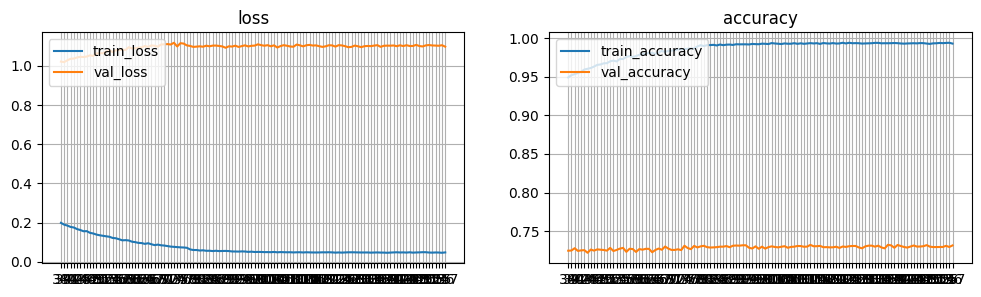

In [33]:
with model1_1.checkpoint(2.3, '120 more SGD') as cp:
    cp.setup(
        epoch_scheduler_cls=torch.optim.lr_scheduler.MultiStepLR, 
        epoch_scheduler_args=dict(milestones=[40, 60, 80], gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=120, metrics=[train.metric_accuracy])
    cp.plot_metrics()


# Model 2

In [221]:
model2 = train.Model('resnet-18-02', resnet18(), '40 Adam with reversion')

Trainable params: 11.2 M. Untrainable params: 0.00. Buffers: 6.00 k.


Initial val_loss=4.6054, val_accuracy=0.0133
Saved model resnet-18-02 checkpoint 1. epoch=0, step=0. val_loss=4.6054, val_accuracy=0.0133
Epoch 1/10: train_loss=3.7908, train_accuracy=0.1182, val_loss=3.3735, val_accuracy=0.1934
Saved model resnet-18-02 checkpoint 1. epoch=1, step=782. train_loss=3.7908, train_accuracy=0.1182, val_loss=3.3735, val_accuracy=0.1934
Epoch 2/10: train_loss=3.0319, train_accuracy=0.2452, val_loss=2.7434, val_accuracy=0.3063
Saved model resnet-18-02 checkpoint 1. epoch=2, step=1564. train_loss=3.0319, train_accuracy=0.2452, val_loss=2.7434, val_accuracy=0.3063
Epoch 3/10: train_loss=2.5409, train_accuracy=0.3359, val_loss=2.4130, val_accuracy=0.3705
Saved model resnet-18-02 checkpoint 1. epoch=3, step=2346. train_loss=2.5409, train_accuracy=0.3359, val_loss=2.4130, val_accuracy=0.3705
Epoch 4/10: train_loss=2.2512, train_accuracy=0.4011, val_loss=2.4333, val_accuracy=0.3769
Saved model resnet-18-02 checkpoint 1. epoch=4, step=3128. train_loss=2.2512, train_a

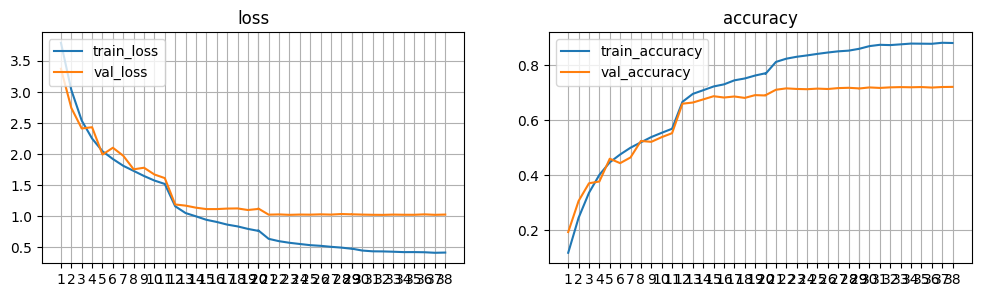

In [222]:
with model2.checkpoint(1) as cp:
    cp.setup(
        loss_cls=torch.nn.CrossEntropyLoss, 
        optimizer_cls=torch.optim.Adam,
        optimizer_args=dict(lr=5e-4, weight_decay=5e-4),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=10, gamma=0.2)
    )

    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.plot_metrics()


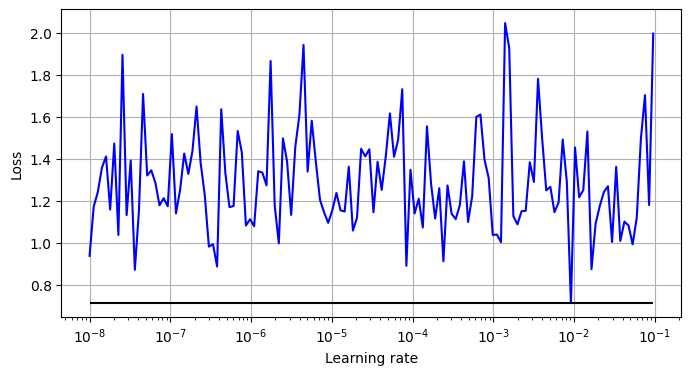

In [223]:
res = model2.cache(1).find_lr(test_dl, optimizer_cls=torch.optim.SGD)
res.plot(end=0.1)

In [224]:
# DEBUG
id(model2.setup_manager), id(model2.checkpoints[1].setup_manager_copy)

(140228339237904, 140228547032976)

Initial val_loss=1.0291, val_accuracy=0.7204
Saved model resnet-18-02 checkpoint 2. epoch=38, step=29716. val_loss=1.0291, val_accuracy=0.7204
Epoch 1/10: train_loss=0.4105, train_accuracy=0.8807, val_loss=1.0271, val_accuracy=0.7191
Epoch 2/10: train_loss=0.4060, train_accuracy=0.8818, val_loss=1.0305, val_accuracy=0.7197
Epoch 3/10: train_loss=0.4065, train_accuracy=0.8832, val_loss=1.0307, val_accuracy=0.7206
Saved model resnet-18-02 checkpoint 2. epoch=41, step=32062. train_loss=0.4065, train_accuracy=0.8832, val_loss=1.0307, val_accuracy=0.7206
Epoch 4/10: train_loss=0.4026, train_accuracy=0.8845, val_loss=1.0301, val_accuracy=0.7205
Epoch 5/10: train_loss=0.4004, train_accuracy=0.8840, val_loss=1.0330, val_accuracy=0.7191
Epoch 6/10: train_loss=0.4011, train_accuracy=0.8839, val_loss=1.0370, val_accuracy=0.7183
Epoch 7/10: train_loss=0.4011, train_accuracy=0.8838, val_loss=1.0326, val_accuracy=0.7204
Epoch 8/10: train_loss=0.3967, train_accuracy=0.8867, val_loss=1.0297, val_accur

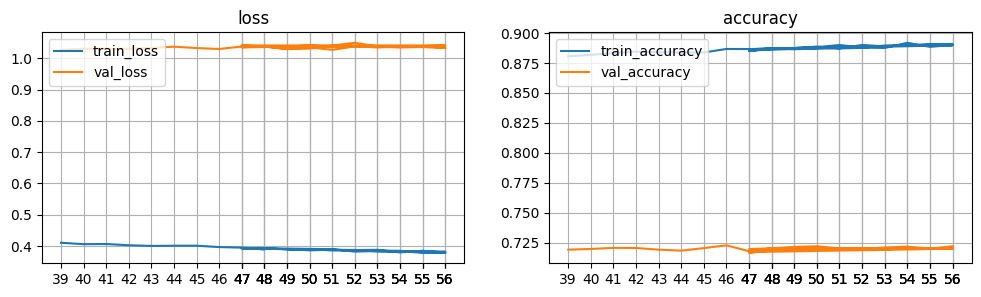

In [225]:
with model2.checkpoint(2, description='40 SGD') as cp:
    cp.setup(
        optimizer_cls=torch.optim.SGD, 
        optimizer_args=dict(weight_decay=5e-4, momentum=0.9, lr=1e-4),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=10, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.plot_metrics()

In [226]:
model2.load_checkpoint(1)

Loaded model resnet-18-02 from checkpoint 1. epoch=38, step=29716. train_loss=0.4181, train_accuracy=0.8797, val_loss=1.0291, val_accuracy=0.7204


Initial val_loss=1.0291, val_accuracy=0.7204
Saved model resnet-18-02 checkpoint 3. epoch=38, step=29716. val_loss=1.0291, val_accuracy=0.7204
Epoch 1/40: train_loss=0.6861, train_accuracy=0.7869, val_loss=1.2054, val_accuracy=0.6758
Epoch 2/40: train_loss=0.6592, train_accuracy=0.7972, val_loss=1.2101, val_accuracy=0.6768
Epoch 3/40: train_loss=0.6333, train_accuracy=0.8055, val_loss=1.2153, val_accuracy=0.6786
Epoch 4/40: train_loss=0.6134, train_accuracy=0.8107, val_loss=1.2077, val_accuracy=0.6785
Epoch 5/40: train_loss=0.5968, train_accuracy=0.8144, val_loss=1.1881, val_accuracy=0.6890
Epoch 6/40: train_loss=0.5621, train_accuracy=0.8283, val_loss=1.1925, val_accuracy=0.6949
Epoch 7/40: train_loss=0.5552, train_accuracy=0.8277, val_loss=1.1893, val_accuracy=0.6903
Epoch 8/40: train_loss=0.5365, train_accuracy=0.8346, val_loss=1.2169, val_accuracy=0.6915
Epoch 9/40: train_loss=0.5220, train_accuracy=0.8386, val_loss=1.1763, val_accuracy=0.6934
Epoch 10/40: train_loss=0.5034, train_

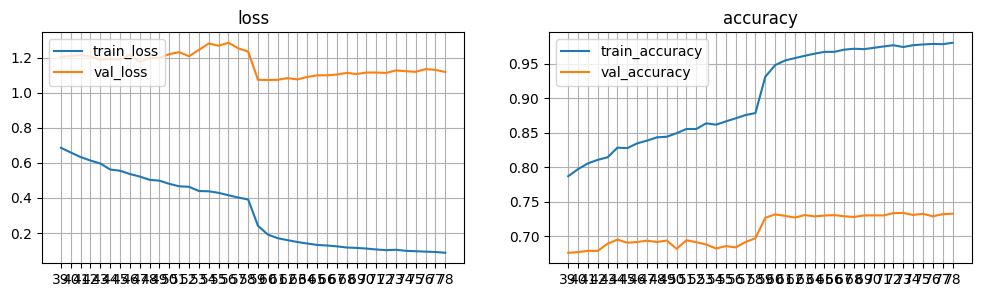

In [227]:
with model2.checkpoint(3, description='40 SGD (after 40 Adam)') as cp:
    cp.setup(
        optimizer_cls=torch.optim.SGD, 
        optimizer_args=dict(weight_decay=5e-4, momentum=0.9, lr=0.1 * 0.2 ** 2),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=20, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=40, metrics=[train.metric_accuracy])
    cp.plot_metrics()

Initial val_loss=1.1279, val_accuracy=0.7337
Saved model resnet-18-02 checkpoint 3.1. epoch=73, step=57086. val_loss=1.1279, val_accuracy=0.7337
Epoch 1/40: train_loss=0.0993, train_accuracy=0.9767, val_loss=1.1266, val_accuracy=0.7291
Epoch 2/40: train_loss=0.0932, train_accuracy=0.9794, val_loss=1.1392, val_accuracy=0.7266
Epoch 3/40: train_loss=0.0917, train_accuracy=0.9794, val_loss=1.1229, val_accuracy=0.7298
Epoch 4/40: train_loss=0.0915, train_accuracy=0.9790, val_loss=1.1289, val_accuracy=0.7319
Epoch 5/40: train_loss=0.0903, train_accuracy=0.9781, val_loss=1.1298, val_accuracy=0.7312
Epoch 6/40: train_loss=0.0856, train_accuracy=0.9806, val_loss=1.1395, val_accuracy=0.7308
Epoch 7/40: train_loss=0.0817, train_accuracy=0.9818, val_loss=1.1431, val_accuracy=0.7284
Epoch 8/40: train_loss=0.0828, train_accuracy=0.9810, val_loss=1.1441, val_accuracy=0.7308
Epoch 9/40: train_loss=0.0802, train_accuracy=0.9825, val_loss=1.1399, val_accuracy=0.7302
Epoch 10/40: train_loss=0.0806, trai

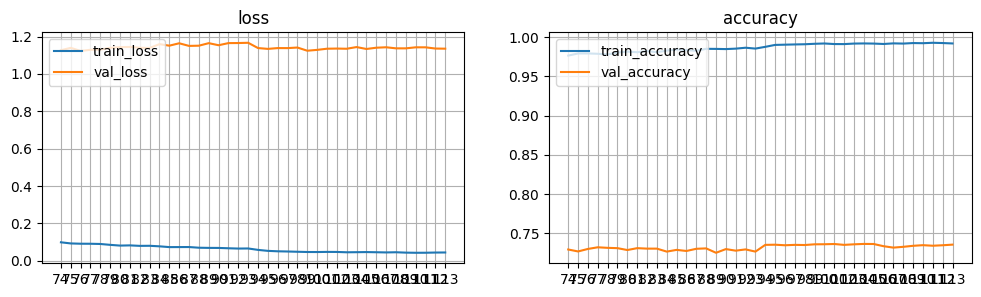

In [228]:
with model2.checkpoint(3.1, description='40 SGD (after 40 Adam)') as cp:
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=40, metrics=[train.metric_accuracy])
    cp.plot_metrics()

In [229]:
model2.load_checkpoint(1)

Loaded model resnet-18-02 from checkpoint 1. epoch=38, step=29716. train_loss=0.4181, train_accuracy=0.8797, val_loss=1.0291, val_accuracy=0.7204


Initial val_loss=1.0291, val_accuracy=0.7204
Saved model resnet-18-02 checkpoint 4.0. epoch=38, step=29716. val_loss=1.0291, val_accuracy=0.7204
Epoch 1/40: train_loss=0.4116, train_accuracy=0.8812, val_loss=1.0330, val_accuracy=0.7180
Epoch 2/40: train_loss=0.4087, train_accuracy=0.8813, val_loss=1.0321, val_accuracy=0.7199
Epoch 3/40: train_loss=0.4052, train_accuracy=0.8838, val_loss=1.0410, val_accuracy=0.7193
Epoch 4/40: train_loss=0.4050, train_accuracy=0.8837, val_loss=1.0363, val_accuracy=0.7183
Epoch 5/40: train_loss=0.3989, train_accuracy=0.8838, val_loss=1.0391, val_accuracy=0.7194
Epoch 6/40: train_loss=0.3972, train_accuracy=0.8856, val_loss=1.0346, val_accuracy=0.7193
Epoch 7/40: train_loss=0.3958, train_accuracy=0.8857, val_loss=1.0373, val_accuracy=0.7205
Saved model resnet-18-02 checkpoint 4.0. epoch=45, step=35190. train_loss=0.3958, train_accuracy=0.8857, val_loss=1.0373, val_accuracy=0.7205
Epoch 8/40: train_loss=0.3918, train_accuracy=0.8862, val_loss=1.0345, val_a

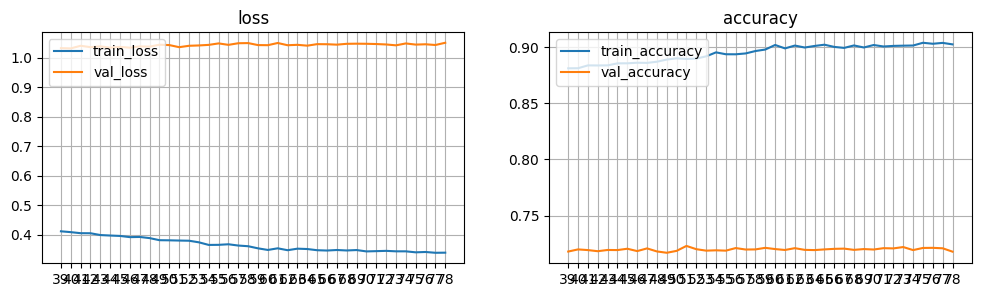

In [230]:
with model2.checkpoint(4.0, description='40 SGD (after 40 Adam)') as cp:
    cp.setup(
        optimizer_cls=torch.optim.SGD, 
        optimizer_args=dict(weight_decay=5e-4, momentum=0.9, lr=0.1 * 0.2 ** 4),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=20, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=40, metrics=[train.metric_accuracy])
    cp.plot_metrics()

In [231]:
model2.load_checkpoint(1)

Loaded model resnet-18-02 from checkpoint 1. epoch=38, step=29716. train_loss=0.4181, train_accuracy=0.8797, val_loss=1.0291, val_accuracy=0.7204


Initial val_loss=1.0363, val_accuracy=0.7230
Saved model resnet-18-02 checkpoint 5.0. epoch=51, step=39882. val_loss=1.0363, val_accuracy=0.7230
Epoch 1/160: train_loss=0.4170, train_accuracy=0.8776, val_loss=1.0899, val_accuracy=0.7083
Epoch 2/160: train_loss=0.4142, train_accuracy=0.8775, val_loss=1.0708, val_accuracy=0.7105
Epoch 3/160: train_loss=0.3973, train_accuracy=0.8816, val_loss=1.0714, val_accuracy=0.7167
Epoch 4/160: train_loss=0.3895, train_accuracy=0.8837, val_loss=1.0948, val_accuracy=0.7078
Epoch 5/160: train_loss=0.3799, train_accuracy=0.8875, val_loss=1.0828, val_accuracy=0.7150
Epoch 6/160: train_loss=0.3723, train_accuracy=0.8901, val_loss=1.0978, val_accuracy=0.7099
Epoch 7/160: train_loss=0.3628, train_accuracy=0.8919, val_loss=1.0924, val_accuracy=0.7131
Epoch 8/160: train_loss=0.3501, train_accuracy=0.8964, val_loss=1.0976, val_accuracy=0.7122
Epoch 9/160: train_loss=0.3436, train_accuracy=0.8987, val_loss=1.1109, val_accuracy=0.7112
Epoch 10/160: train_loss=0.

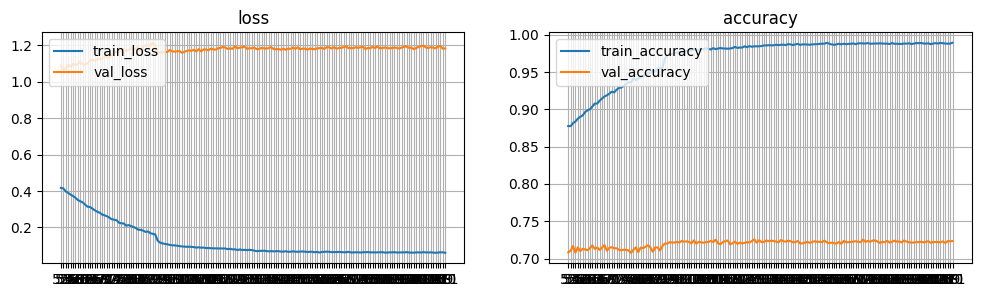

In [232]:
with model2.checkpoint(5.0, description='160 SGD (after 40 Adam)') as cp:
    cp.setup(
        optimizer_cls=torch.optim.SGD, 
        optimizer_args=dict(weight_decay=5e-4, momentum=0.9, lr=0.1 * 0.2 ** 3),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=40, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=160, metrics=[train.metric_accuracy])
    cp.plot_metrics()

---

In [233]:
model2.load_checkpoint(1)

Loaded model resnet-18-02 from checkpoint 1. epoch=38, step=29716. train_loss=0.4181, train_accuracy=0.8797, val_loss=1.0291, val_accuracy=0.7204


# Model 3

In [234]:
model3 = train.Model('resnet-18-03', resnet18(), '160 SGD')

Trainable params: 11.2 M. Untrainable params: 0.00. Buffers: 6.00 k.


Initial val_loss=4.6058, val_accuracy=0.0114
Saved model resnet-18-03 checkpoint 1. epoch=0, step=0. val_loss=4.6058, val_accuracy=0.0114
Epoch 1/160: train_loss=3.9774, train_accuracy=0.0887, val_loss=3.6935, val_accuracy=0.1279
Saved model resnet-18-03 checkpoint 1. epoch=1, step=782. train_loss=3.9774, train_accuracy=0.0887, val_loss=3.6935, val_accuracy=0.1279
Epoch 2/160: train_loss=3.3304, train_accuracy=0.1871, val_loss=3.1420, val_accuracy=0.2252
Saved model resnet-18-03 checkpoint 1. epoch=2, step=1564. train_loss=3.3304, train_accuracy=0.1871, val_loss=3.1420, val_accuracy=0.2252
Epoch 3/160: train_loss=2.8509, train_accuracy=0.2764, val_loss=3.0031, val_accuracy=0.2665
Saved model resnet-18-03 checkpoint 1. epoch=3, step=2346. train_loss=2.8509, train_accuracy=0.2764, val_loss=3.0031, val_accuracy=0.2665
Epoch 4/160: train_loss=2.5079, train_accuracy=0.3436, val_loss=2.5632, val_accuracy=0.3498
Saved model resnet-18-03 checkpoint 1. epoch=4, step=3128. train_loss=2.5079, tra

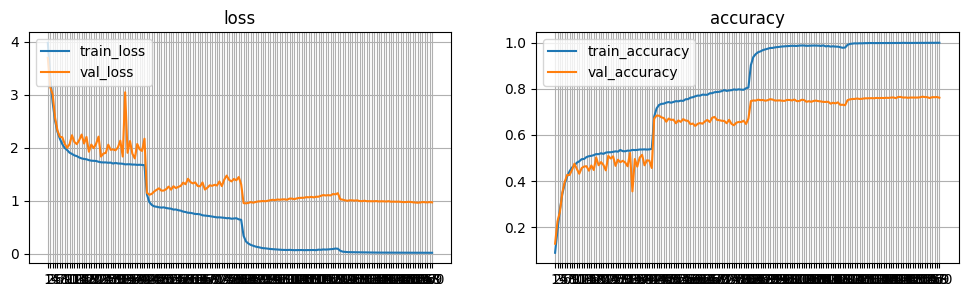

In [235]:
with model3.checkpoint(1) as cp:
    cp.setup(
        loss_cls=torch.nn.CrossEntropyLoss, 
        optimizer_cls=torch.optim.SGD, 
        optimizer_args=dict(weight_decay=5e-4, momentum=0.9, lr=0.1),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=40, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=160, metrics=[train.metric_accuracy])
    cp.plot_metrics()

# Model 4

In [236]:
model4 = train.Model('resnet-18-04', resnet18(), '40 x 4 SGD with reversion')

Trainable params: 11.2 M. Untrainable params: 0.00. Buffers: 6.00 k.


Initial val_loss=4.6053, val_accuracy=0.0096
Saved model resnet-18-04 checkpoint 1. epoch=0, step=0. val_loss=4.6053, val_accuracy=0.0096
Epoch 1/40: train_loss=3.9781, train_accuracy=0.0891, val_loss=3.6893, val_accuracy=0.1425
Saved model resnet-18-04 checkpoint 1. epoch=1, step=782. train_loss=3.9781, train_accuracy=0.0891, val_loss=3.6893, val_accuracy=0.1425
Epoch 2/40: train_loss=3.3350, train_accuracy=0.1854, val_loss=3.0608, val_accuracy=0.2403
Saved model resnet-18-04 checkpoint 1. epoch=2, step=1564. train_loss=3.3350, train_accuracy=0.1854, val_loss=3.0608, val_accuracy=0.2403
Epoch 3/40: train_loss=2.8464, train_accuracy=0.2759, val_loss=2.7515, val_accuracy=0.3041
Saved model resnet-18-04 checkpoint 1. epoch=3, step=2346. train_loss=2.8464, train_accuracy=0.2759, val_loss=2.7515, val_accuracy=0.3041
Epoch 4/40: train_loss=2.5334, train_accuracy=0.3398, val_loss=2.5060, val_accuracy=0.3595
Saved model resnet-18-04 checkpoint 1. epoch=4, step=3128. train_loss=2.5334, train_a

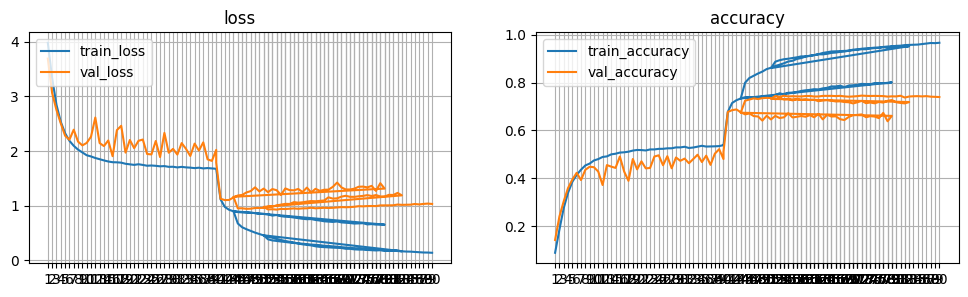

In [237]:
with model4.checkpoint(1) as cp:
    cp.setup(
        loss_cls=torch.nn.CrossEntropyLoss, 
        optimizer_cls=torch.optim.SGD, 
        optimizer_args=dict(weight_decay=5e-4, momentum=0.9, lr=0.1),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=40, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=40, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=40, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=40, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=40, metrics=[train.metric_accuracy])
    cp.plot_metrics()

# Model 5

In [238]:
model5 = train.Model('resnet-18-05', resnet18(), '160 Adam')

Trainable params: 11.2 M. Untrainable params: 0.00. Buffers: 6.00 k.


Initial val_loss=4.6059, val_accuracy=0.0056
Saved model resnet-18-05 checkpoint 1. epoch=0, step=0. val_loss=4.6059, val_accuracy=0.0056
Epoch 1/160: train_loss=3.7938, train_accuracy=0.1176, val_loss=3.4388, val_accuracy=0.1701
Saved model resnet-18-05 checkpoint 1. epoch=1, step=782. train_loss=3.7938, train_accuracy=0.1176, val_loss=3.4388, val_accuracy=0.1701
Epoch 2/160: train_loss=3.0117, train_accuracy=0.2466, val_loss=2.8480, val_accuracy=0.2788
Saved model resnet-18-05 checkpoint 1. epoch=2, step=1564. train_loss=3.0117, train_accuracy=0.2466, val_loss=2.8480, val_accuracy=0.2788
Epoch 3/160: train_loss=2.5408, train_accuracy=0.3359, val_loss=2.5341, val_accuracy=0.3516
Saved model resnet-18-05 checkpoint 1. epoch=3, step=2346. train_loss=2.5408, train_accuracy=0.3359, val_loss=2.5341, val_accuracy=0.3516
Epoch 4/160: train_loss=2.2494, train_accuracy=0.4011, val_loss=2.4147, val_accuracy=0.3730
Saved model resnet-18-05 checkpoint 1. epoch=4, step=3128. train_loss=2.2494, tra

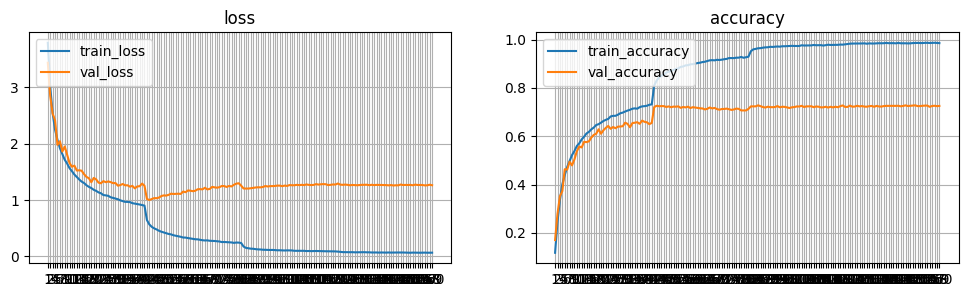

In [239]:
with model5.checkpoint(1) as cp:
    cp.setup(
        loss_cls=torch.nn.CrossEntropyLoss, 
        optimizer_cls=torch.optim.Adam,
        optimizer_args=dict(lr=5e-4, weight_decay=5e-4),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=40, gamma=0.2)
    )

    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=160, metrics=[train.metric_accuracy])
    cp.plot_metrics()
